<a href="https://colab.research.google.com/github/drawcodeboy/Cat_n_Dog_Classification/blob/main/ver2(3)_cat_n_dog_modeling_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [ ]:
# Modeling

# 1st Conv
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',  
                              padding = 'same', input_shape=(224, 224, 1),
                              kernel_regularizer=keras.regularizers.l2(0.002)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Dropout(0.2))
# 2nd Conv
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', 
                              padding = 'same',
                              kernel_regularizer=keras.regularizers.l2(0.002)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Dropout(0.2))
# 3rd Conv
model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', 
                              padding = 'same',
                              kernel_regularizer=keras.regularizers.l2(0.002)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Dropout(0.2))
# Dense
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu',
                             kernel_regularizer=keras.regularizers.l2(0.002)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

Batch Normalization reference
https://eehoeskrap.tistory.com/430
L2 Regularization (1)
https://junstar92.tistory.com/102
L2 Regularization (2)
https://www.kaggle.com/general/226433

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 64)    

In [ ]:
train_path = '/content/drive/MyDrive/cat_n_dog/data_scaled_numpy/training_set_scaled'
train_path_list = []

for dirname, _, filenames in os.walk(train_path):
    for filename in filenames:
        if(filename.endswith('npy')):
            train_set_part_path = os.path.join(dirname, filename)
            train_path_list.append(train_set_part_path)

train_path_list.sort()

In [ ]:
train_target_path = '/content/drive/MyDrive/cat_n_dog/data_scaled_numpy/train_target_part'
train_target_path_list = []

for dirname, _, filenames in os.walk(train_target_path):
    for filename in filenames:
        if(filename.endswith('npy')):
            train_target_part_path = os.path.join(dirname, filename)
            train_target_path_list.append(train_target_part_path)
        
train_target_path_list.sort()

In [ ]:
# Load Dataset

train_set = []
train_target = []

for x_path, y_path in zip(train_path_list, train_target_path_list):
    a = np.load(x_path, allow_pickle=True)
    b = np.load(y_path, allow_pickle=True)

    for x in a:
        train_set.append(x)
    for y in b:
        train_target.append(y)

    del a
    del b

train_set = np.array(train_set)
train_target = np.array(train_target)

In [ ]:
print(train_set[0][125][100])

0.3764706


In [ ]:
import collections

collections.Counter(train_target)

Counter({1: 16020, 0: 16000})

count value in numpy reference
http://daplus.net/python-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%97%90%EC%84%9C-ndarray%EC%97%90%EC%84%9C-%ED%8A%B9%EC%A0%95-%ED%95%AD%EB%AA%A9%EC%9D%98-%EB%B0%9C%EC%83%9D%EC%9D%84-%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94/

In [ ]:
# train_set, validation_set 분리
x_train, x_val, y_train, y_val = train_test_split(
    train_set, train_target, test_size=0.06, random_state=42 # 약 2,000개만 val_set으로 사용
)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

early_stopping_cb = keras.callbacks.EarlyStopping(patience=6, verbose=1,
                                                  restore_best_weights=True)

learning_rate_reduction_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', patience = 4, verbose=1, factor=0.5, min_lr=0.00001
)

* Early Stopping의 patience에 대해 모호한 점

연속적으로 monitoring 하는 값이 작아져서 patience 값에 해당하는 개수에 도달할 때인가

아니면 작아지는 때가 총괄적으로 patience 값에 해당하는 개수 도달했을 때인가

Keras Github Callback Source Reference
https://github.com/keras-team/keras/blob/master/keras/callbacks.py

```
Example:
    >>> callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    >>> # This callback will stop the training when there is no improvement in
    >>> # the loss for three consecutive epochs.
```
>연속적으로(consecutive) 작아질 때 patience 값에 대해 고려함

In [18]:
# Training
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),
               callbacks=[early_stopping_cb, learning_rate_reduction_cb], batch_size = 16)

Epoch 1/50
1882/1882 [==============================] - 850s 451ms/step - loss: 2.3596 - accuracy: 0.6404 - val_loss: 1.8039 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 2/50
1882/1882 [==============================] - 846s 449ms/step - loss: 1.7982 - accuracy: 0.7036 - val_loss: 1.8709 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 3/50
1882/1882 [==============================] - 841s 447ms/step - loss: 1.7874 - accuracy: 0.7152 - val_loss: 2.9096 - val_accuracy: 0.5193 - lr: 0.0010
Epoch 4/50
1882/1882 [==============================] - 844s 449ms/step - loss: 1.6893 - accuracy: 0.7322 - val_loss: 1.7016 - val_accuracy: 0.5687 - lr: 0.0010
Epoch 5/50
1882/1882 [==============================] - ETA: 0s - loss: 1.4007 - accuracy: 0.7517
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1882/1882 [==============================] - 843s 448ms/step - loss: 1.4007 - accuracy: 0.7517 - val_loss: 1.4269 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 6/50
1882/1882 [==========

In [19]:
def show_graph(history_):
    accuracy = history_.history['accuracy']
    val_accuracy = history_.history['val_accuracy']
    loss = history_.history['loss']
    val_loss = history_.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 2))

    plt.subplot(121)
    plt.ylim(0, 1.1)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()

reference
https://chealin93.tistory.com/69

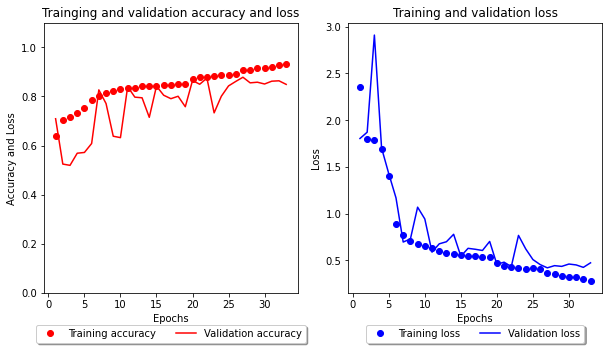

In [20]:
show_graph(history)

In [21]:
# Load Test Set

test_set = np.load('/content/drive/MyDrive/cat_n_dog/data_scaled_numpy/test_set_scaled/test_scaled.npy', allow_pickle=True)
test_target = np.load('/content/drive/MyDrive/cat_n_dog/data_numpy/test_target.npy', allow_pickle=True)

In [22]:
print(test_set.shape)

(2023, 224, 224)


In [23]:
test_set_scaled = test_set

model.evaluate(test_set_scaled, test_target)

64/64 [==============================] - 6s 100ms/step - loss: 0.4306 - accuracy: 0.8789


[0.43055757880210876, 0.878892719745636]

In [24]:
def print_predict(sample_):
    result = model.predict(sample_)
    result = result[0][0]
    

    print('RESULT: ', end='')
    if(result < 0.5):
        print('Cat')
    elif(result > 0.5):
        print('Dog')
    else:
        print('Can\'t know')

In [25]:
def crop_center(img):
    y, x, z = img.shape
    crop_size = min(y, x)

    start_x = x // 2 - (crop_size // 2)
    start_y = y // 2 - (crop_size // 2)
    img = img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    if crop_size < 224: # 확대 할 때, 바이큐빅 보간법
        return cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    elif crop_size > 224: # 축소할 때, 영역 보간법
        return cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    else:
        return img

In [26]:
from tensorflow.keras.preprocessing import image
import cv2

def predict_fun(sample_path):
    sample = image.load_img(sample_path)
    sample_np = np.array(sample, dtype=np.float32)
    sample_np = sample_np / 255.0
    sample_crop = crop_center(sample_np)
    sample_gray = cv2.cvtColor(sample_crop, cv2.COLOR_BGR2GRAY)
    sample_ = sample_gray.reshape(1, 224, 224, 1)

    print_predict(sample_)
    plt.imshow(sample)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 51ms/step
RESULT: Cat


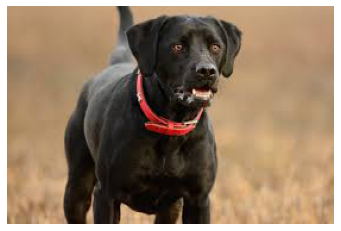

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


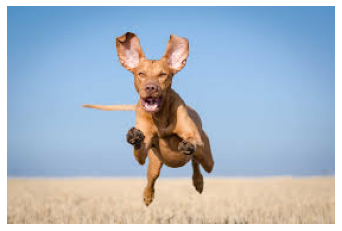

1/1 [==============================] - 0s 52ms/step
RESULT: Cat


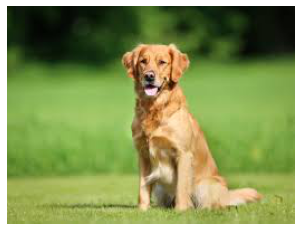

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


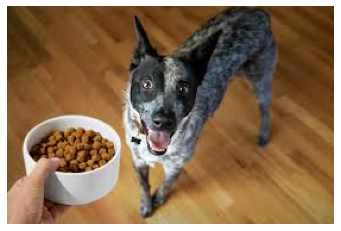

1/1 [==============================] - 0s 49ms/step
RESULT: Dog


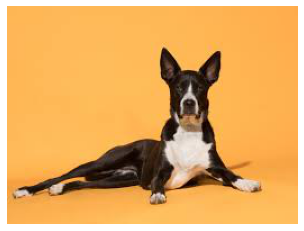

1/1 [==============================] - 0s 51ms/step
RESULT: Dog


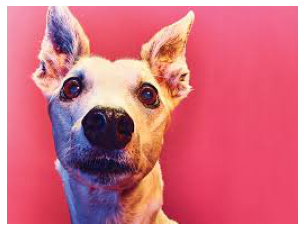

1/1 [==============================] - 0s 51ms/step
RESULT: Cat


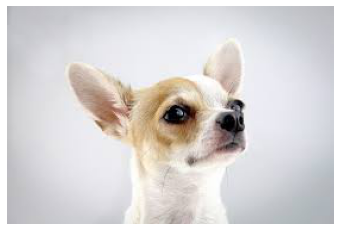

1/1 [==============================] - 0s 53ms/step
RESULT: Dog


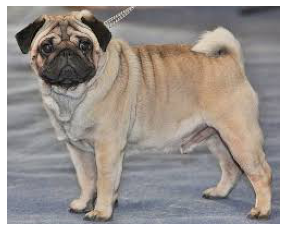

1/1 [==============================] - 0s 51ms/step
RESULT: Cat


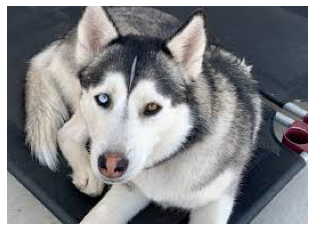

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


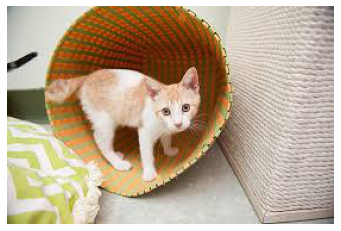

1/1 [==============================] - 0s 51ms/step
RESULT: Cat


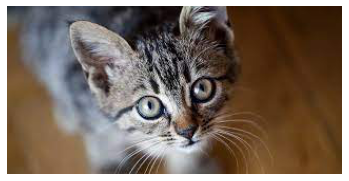

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


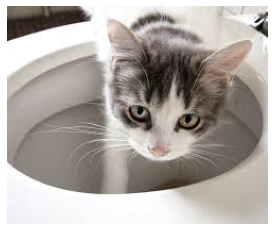

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


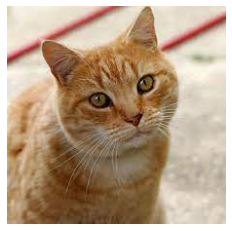

1/1 [==============================] - 0s 51ms/step
RESULT: Cat


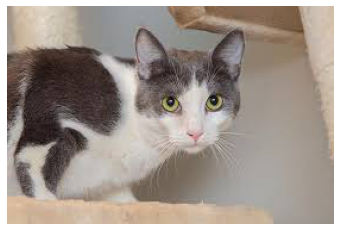

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


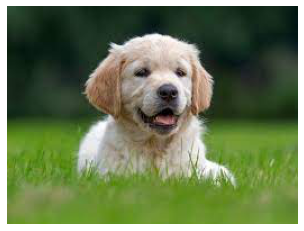

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


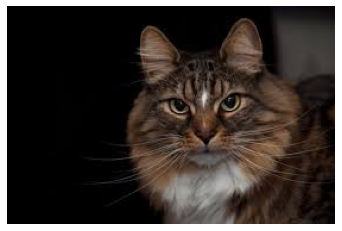

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


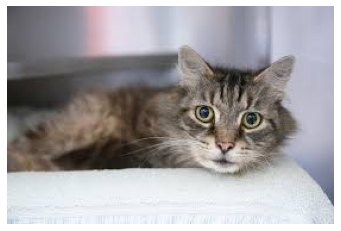

1/1 [==============================] - 0s 52ms/step
RESULT: Dog


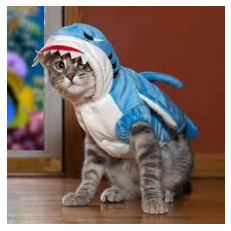

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


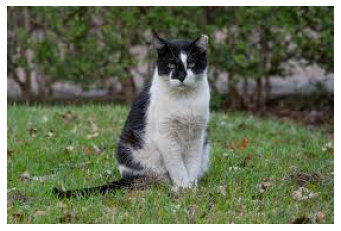

1/1 [==============================] - 0s 50ms/step
RESULT: Cat


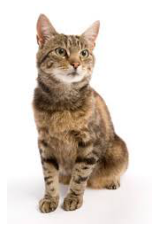

1/1 [==============================] - 0s 49ms/step
RESULT: Cat


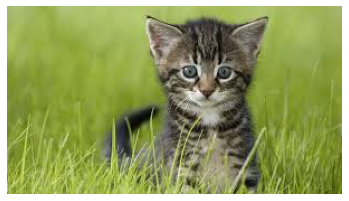

1/1 [==============================] - 0s 50ms/step
RESULT: Dog


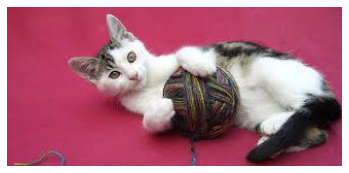

1/1 [==============================] - 0s 51ms/step
RESULT: Dog


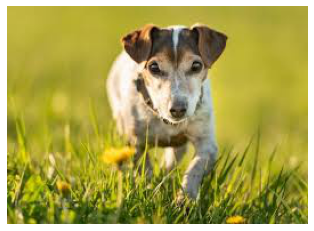

In [29]:
no_dataset_path = '/content/drive/MyDrive/cat_n_dog/no_dataset/cat_n_dog_test'

for dirname, _, filenames in os.walk(no_dataset_path):
    for filename in filenames:
        no_data_path = os.path.join(dirname, filename)
        predict_fun(no_data_path)

In [28]:
model.save('ver2_cat_n_dog_model.h5')